# Danish Parliament Speech Corpus

In [1]:
##

## 1) Explore xml file and create a dataframe with the appropriate data

### 1.1) Import Modules

In [2]:
import pandas as pd
import xml.etree.ElementTree as et
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import xml.dom.minidom

import numpy as np
nltk.download('stopwords')
import string
import re
import lemmy
lemmatizer = lemmy.load("da")


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\george\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.2) Print xml file in a pretty format to see the structure

We firstly print a part of the xml file to observe the structure and then we try to 

In [3]:
dom = xml.dom.minidom.parse("EdixiXMLExport_20161.xml") # or xml.dom.minidom.parseString(xml_string)
pretty_xml = dom.toprettyxml()
print(pretty_xml[:2000])

<?xml version="1.0" ?>
<EdixiData>
	<Møder>
		<Samling>20161</Samling>
		<Møde>
			<MeetingId>8B63C26F-EF84-4201-B21B-00715885D093</MeetingId>
			<Location>Folketingssalen</Location>
			<DateOfSitting>2016-10-04T12:00:00</DateOfSitting>
			<Mødenummer>1. møde</Mødenummer>
			<Dagsordenpunkt>
				<Punktnummer>0</Punktnummer>
				<Mødetitel>
					<Exitus>
						<Linea>
							<Char/>
						</Linea>
					</Exitus>
				</Mødetitel>
				<Dagsordenpunkt>Punkt 0</Dagsordenpunkt>
				<Sagstype>Formandens meddelelser</Sagstype>
				<Tale>
					<Starttid>2016-10-04T12:00:01.510</Starttid>
					<Sluttid>2016-10-04T12:01:06.487</Sluttid>
					<Navn>Bertel Haarder</Navn>
					<Rolle>aldersformanden</Rolle>
					<Tekst>Mødet er åbnet.Deres Majestæt, Deres Kongelige Højheder, ærede gæster og medlemmer.Ifølge grundlovens § 36 går folketingsåret fra den første tirsdag i oktober til den første tirsdag i oktober næste år, og på den dag skal Folketinget sættes på ny, som der står.Som det medlem, der længs

In [4]:
xtree = et.parse("EdixiXMLExport_20161.xml")
xroot = xtree.getroot()

### 1.3) Create a dataframe to store data

In [6]:
keys = {'Starttid', 'Sluttid', 'Navn', 'Parti', 'Rolle', 'Tekst'}
d = dict([(key, []) for key in keys])

In [7]:
def filter_out(empty_dic, current_label, previous_label):
    ''' This function checks if some of the required data are 
    ignored in the xml file to add a None value to the dataset'''
    
    if current_label == 'Sluttid' and previous_label != "Starttid":
        empty_dic['Starttid'].append('None')
    if current_label == 'Navn' and previous_label != "Sluttid":
        empty_dic['Sluttid'].append('None')
    if current_label == 'Parti' and previous_label != "Navn":
        empty_dic['Navn'].append('None')
    if current_label == 'Rolle' and previous_label != "Parti":
        empty_dic['Parti'].append('None')
    if current_label == 'Tekst' and previous_label != "Rolle":
        empty_dic['Rolle'].append('None')
    if current_label == 'Starttid' and previous_label != "Tekst":
        empty_dic['Tekst'].append('None')

In [8]:
la = 'Tekst'
for child in xroot:
    for ch in child:
        for c in ch:
            for b in c:
                for a in b:
                    if a.tag != 'Exitus' and a.tag != 'PreTekst' and a.tag != 'SkriftligBegrundelse':
                        label = a.tag
                        filter_out(d, label, la)
                        d[label].append(a.text)
                        la = a.tag

### 1.4) Finally we have the dataframe

In [9]:
df = pd.DataFrame(d)
df

,Tekst,Parti,Starttid,Rolle,Sluttid,Navn
0,"Mødet er åbnet.Deres Majestæt, Deres Kongelige...",None,2016-10-04T12:00:01.510,aldersformanden,2016-10-04T12:01:06.487,Bertel Haarder
1,"Jeg vil gerne sige mange tak for den tillid, s...",None,2016-10-04T12:01:43.633,formand,2016-10-04T12:02:54.080,None
2,Jeg byder velkommen til vore gæster i dag. Hje...,None,2016-10-04T12:02:54.080,formand,2016-10-04T12:03:53.620,None
3,Herefter er der tilbage at fremsætte tre lovfo...,None,2016-10-04T12:47:34.897,formand,2016-10-04T12:48:16.400,None
4,"Til formand har Socialdemokratiet, Dansk Folke...",None,2016-10-04T12:01:06.487,aldersformanden,2016-10-04T12:01:10.887,Bertel Haarder
...,...,...,...,...,...,...
48682,"Jeg kan ikke sætte procentsatser på, hvad man ...",None,2017-01-26T16:10:37.993,minister,2017-01-26T16:11:10.913,Anders Samuelsen
48683,Hr. René Gade.,None,2017-01-26T16:11:10.913,formand,2017-01-26T16:11:15.057,Henrik Dam Kristensen
48684,"Tak for svaret, men jeg mente egentlig mere i ...",ALT,2017-01-26T16:11:15.057,medlem,2017-01-26T16:11:21.597,René Gade
48685,Det synes jeg lyder fornuftigt.,None,2017-01-26T16:11:21.597,minister,2017-01-26T16:11:24.373,Anders Samuelsen


Now we have a dataset with the required information about every speech. Let's apply some preprocessing steps along with some exploratory analysis! 

## 2) Exploratory Analysis and text preprocessing

### 2.1) Count the number of speeches per role and per party

In [10]:
Rolle_df = df.Rolle.value_counts().rename_axis('Rolle').to_frame("No")
Rolle_df

,No
Rolle,
formand,25150
medlem,18818
minister,4616
fungerende minister,101
aldersformanden,2


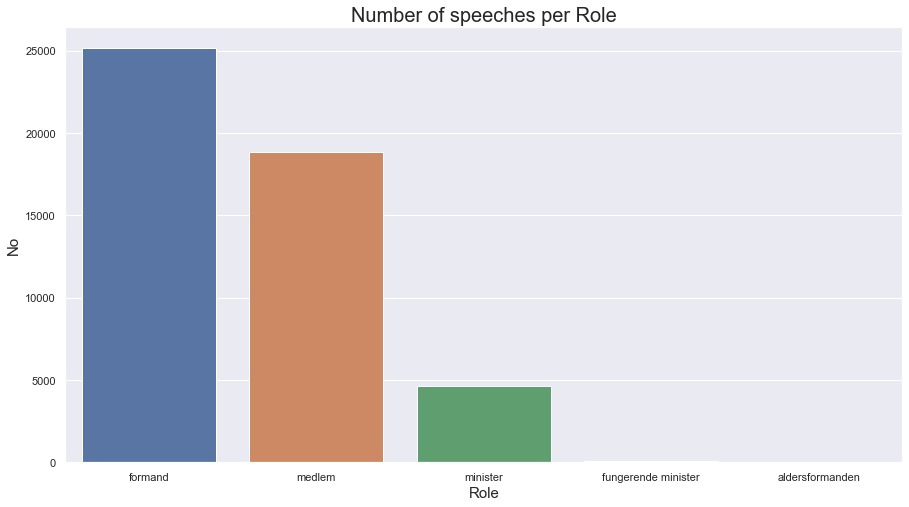

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

plt.figure(figsize=(15,8))
sns.set(font_scale = 1)
a = sns.barplot(Rolle_df.index, Rolle_df.No.values.tolist())#.set(title='Number of speeches per Role')
a.axes.set_title('Number of speeches per Role',fontsize=20)
a.set_xlabel("Role",fontsize=15)
a.set_ylabel("No",fontsize=15)
plt.show()

We decide to hold only the speeces coming from simple members *'medlem'* of the parliament

In [12]:
df = df[df.Rolle == 'medlem']
Parti_df = df.Parti.value_counts().rename_axis('Parti').to_frame("No")
Parti_df

,No
Parti,
S,3886
DF,3277
EL,3048
V,1972
ALT,1582
SF,1578
LA,1309
RV,1153
KF,695


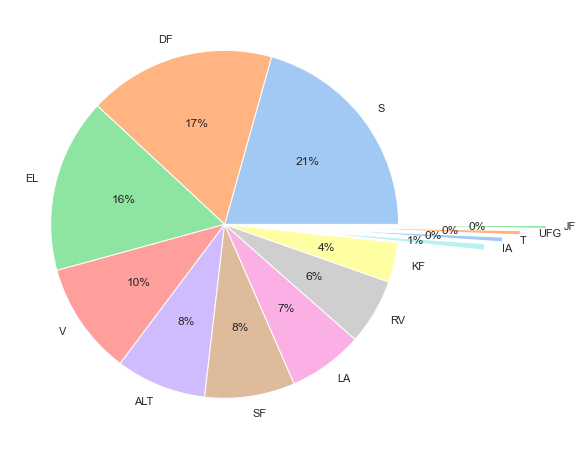

In [13]:
#define data
data = Parti_df.No.values.tolist()
labels = Parti_df.index

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:15]
explode = [0,0,0,0,0,0,0,0,0,0.5,0.6,0.7,0.85]

#create pie chart
plt.figure(figsize=(15,8))
sns.set(font_scale = 1)
plt.pie(data, labels = labels, colors = colors, explode=explode, autopct='%.0f%%')
plt.show()

Hold only 2 parties in order to formulate a binary classification problem

In [14]:
df = df[(df.Parti == "DF") | (df.Parti == "EL")]

### 2.2) Text preprocessing

Exploring the texts, we made some key observations concerning the preprocessing steps. 

* Firstly, it is necessary to remove punctuation. For this reason we created the `remove_punctuation` function.  We point out here that the `string.punctuation` module does not remove some characters like '«»–½' so we need an extra command to remove these characters.

* Moreover it is quite common when we are not interested in numbers or quantities in NLP projects to replace all numbers with the word "NUM". For this reason we created the function `replace_num` to replace any kind of number.

* Lastly we noticed that there were a lot of cases where there was not a space after a dot or a comma. To fix this problem we created the function `space_after_dot_comma` .

In [15]:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    PUNCT_TO_REMOVE = string.punctuation
    text = re.sub('[«»–½]', '', text)
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def replace_num(text):
    """custom function to replace numbers"""
    rx = re.compile(r'(?<=\d)(?=[^\d\s])|(?<=[^\d\s])(?=\d)')
    text = rx.sub(' ', text)
    
    DIGIT_RX = "\d+\.?\d+"
    new_text = re.sub(DIGIT_RX, "NUM", text)
    return new_text

def space_after_dot_comma(text):
    """custom function to put space after dot comma"""
    return re.sub(r'(?<=[.,])(?=[^\s])', r' ', text)

The following function applies some preprocessing steps and counts the number of the sentences for each speech

In [16]:
def sentence_counter(text):
    """custom function to count the sentences"""
    text = replace_num(text)
    text = space_after_dot_comma(text)
    text = re.sub('[«»-½]', '', text)
    #number_of_sentences = len(sent_tokenize(text, language='danish'))
    #return number_of_sentences
    #print(sent_tokenize(text, language='danish'))
    return len(sent_tokenize(text, language='danish'))

df['Num_of_sent'] = df["Tekst"].apply(sentence_counter)

The following function is applying word **Tokenization** after some preprocessing steps.

In [17]:
def text_pre_pro(text):
    # change every number with num
    new_text = replace_num(text)
    # Put space after comma or dot
    new_text = space_after_dot_comma(new_text)
    #Remove punctuation and lowercase
    new_text = remove_punctuation(new_text).lower()
    #Tokenize
    tokens = nltk.word_tokenize(new_text, language='danish')
    #Remove Stopwords
    new_token = [word for word in tokens if word not in stopwords.words('danish')]
    return new_token

def word_counter(text):
    return len(text_pre_pro(text))

In [18]:
df['Num_of_words'] = df["Tekst"].apply(word_counter)

In [19]:
df['Tokens'] = df["Tekst"].apply(text_pre_pro)

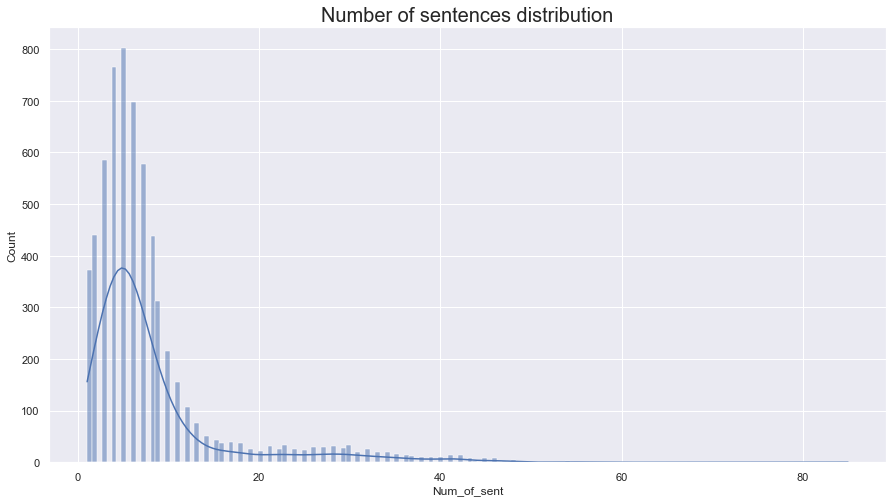

In [20]:
plt.figure(figsize=(15,8))
a = sns.histplot(data=df, x="Num_of_sent", kde=True)
a.axes.set_title('Number of sentences distribution',fontsize=20)
plt.show()

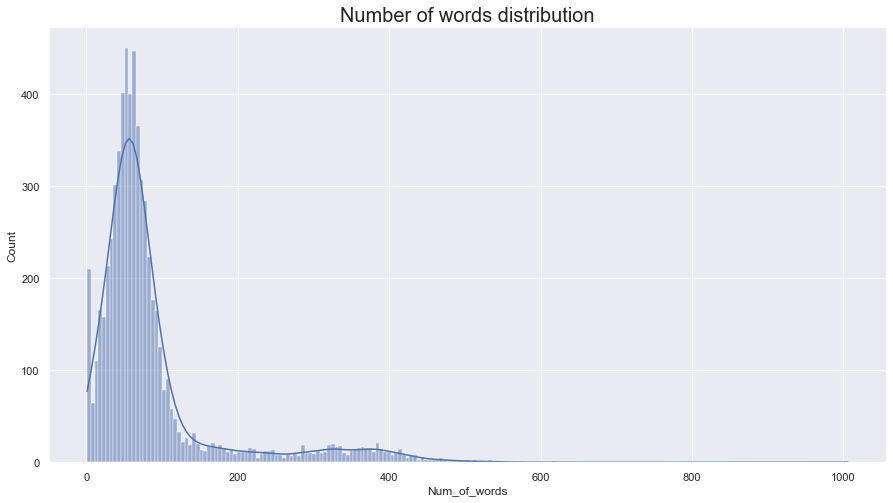

In [21]:
plt.figure(figsize=(15,8))
a = sns.histplot(data=df, x="Num_of_words", kde=True)
a.axes.set_title('Number of words distribution',fontsize=20)
plt.show()

The following function is applying **Lemmatization** in our texts.

In [22]:
def lem_matize(words):
    new_tok =[]
    for i in words:
        new_tok.append(lemmatizer.lemmatize("",i)[0])
    return new_tok

df["Lem_tok"] = df.Tokens.apply(lem_matize)

In [23]:
def detokenize(list_):
    return ' '.join(list_)

df["Pre_pro_text"] = df['Lem_tok'].apply(detokenize)

In [24]:
frequency_of_words = df.Pre_pro_text.str.split(expand=True).stack().value_counts().reset_index()
frequency_of_words.columns=["Word","Freq"]
frequency_of_words

,Word,Freq
0,se,18697
1,kunne,11592
2,sige,6486
3,få,6127
4,num,5627
...,...,...
21078,forbryderfabrik,1
21079,rockerborgsrapport,1
21080,tilgodehavende,1
21081,fodboldsprog,1


Our dataset finally has the following form:
    

In [25]:
df

,Tekst,Parti,Starttid,Rolle,Sluttid,Navn,Num_of_sent,Num_of_words,Tokens,Lem_tok,Pre_pro_text
36,"Det er jo en dejlig dag i dag, solen skinner, ...",DF,2017-05-04T10:18:00.027,medlem,2017-05-04T10:23:04.130,Mette Hjermind Dencker,22,393,"[dejlig, dag, dag, solen, skinner, forår, lige...","[dejlig, dag, dag, solen, skinne, forår, lige,...",dejlig dag dag solen skinne forår lige lidt ud...
40,"Som andre har givet udtryk for, vil jeg også p...",EL,2017-05-04T10:25:17.347,medlem,2017-05-04T10:30:36.337,Henning Hyllested,39,379,"[andre, givet, udtryk, enhedslistens, vegne, g...","[anden, givet, udtrykke, enhedsliste, vegne, g...",anden givet udtrykke enhedsliste vegne give ud...
54,"Det drejer sig bare om det, som ministeren næv...",EL,2017-05-04T10:42:20.080,medlem,2017-05-04T10:43:12.140,Henning Hyllested,5,52,"[drejer, bare, ministeren, nævner, svar, spørg...","[drejer, bare, minister, nævner, svar, spørgsm...",drejer bare minister nævner svar spørgsmål nr ...
61,"Jeg synes, det er meget ærgerligt, at Socialde...",EL,2017-05-04T10:46:32.627,medlem,2017-05-04T10:47:27.130,Maria Reumert Gjerding,5,58,"[synes, ærgerligt, socialdemokraternes, ordfør...","[synes, ærgerlig, socialdemokrat, ordfører, mø...",synes ærgerlig socialdemokrat ordfører møde da...
65,"Jeg synes, ordføreren skal svare på spørgsmåle...",EL,2017-05-04T10:47:54.107,medlem,2017-05-04T10:48:19.520,Maria Reumert Gjerding,3,30,"[synes, ordføreren, svare, spørgsmålet, går, o...","[synes, ordfører, svar, spørgsmål, går, ordfør...",synes ordfører svar spørgsmål går ordfører eni...
...,...,...,...,...,...,...,...,...,...,...,...
48638,"Jo, de to ting hænger sådan set overhovedet ik...",EL,2017-01-26T15:41:30.963,medlem,2017-01-26T15:42:07.720,Søren Søndergaard,6,55,"[to, ting, hænger, set, overhovedet, sammen, b...","[to, tinge, hænge, se, overhovedet, sammen, ba...",to tinge hænge se overhovedet sammen bare ford...
48642,Det er alene et spørgsmål om prioritering. Som...,EL,2017-01-26T15:42:53.943,medlem,2017-01-26T15:43:48.180,Søren Søndergaard,5,66,"[alene, spørgsmål, prioritering, nævnte, syrie...","[ale, spørgsmål, prioritering, nævne, syrien, ...",ale spørgsmål prioritering nævne syrien frontl...
48658,"Tak. Jeg troede, jeg havde en aftale med hr. R...",EL,2017-01-26T15:58:24.690,medlem,2017-01-26T15:59:13.380,Søren Søndergaard,6,57,"[tak, troede, aftale, hr, rasmus, jarlov, fork...","[tak, tro, aftale, hr, rasmus, jarlov, forklar...",tak tro aftale hr rasmus jarlov forklare tilfø...
48662,"Undskyld, men tror hr. Rasmus Jarlov virkelig,...",EL,2017-01-26T16:00:04.600,medlem,2017-01-26T16:00:47.237,Søren Søndergaard,5,52,"[undskyld, tror, hr, rasmus, jarlov, virkelig,...","[undskyld, tro, hr, rasmus, jarlov, virkelig, ...",undskyld tro hr rasmus jarlov virkelig amerika...


There are 4020727 words in the combination of all speeches.


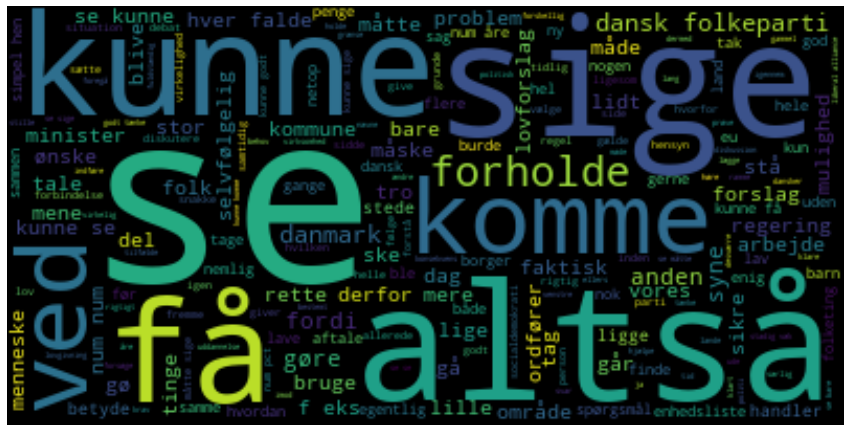

In [26]:
text1 = " ".join(speech for speech in df.Pre_pro_text)
print ("There are {} words in the combination of all speeches.".format(len(text1)))
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt


# Generate a word cloud image
wordcloud = WordCloud(background_color="black").generate(text1)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 2.3) Create tf-idf vectorization igoring most common/rare words

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
#v = TfidfVectorizer(max_features=1000, max_df=0.30, min_df=0.005)
v = TfidfVectorizer(max_df=0.3, min_df=0.01)
x = v.fit_transform(df['Pre_pro_text'])

In [28]:
x.shape

(6325, 990)